<a href="https://colab.research.google.com/github/dlkt101101/STAT441-Project/blob/main/STAT441_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
Prepared by:\
Darren Alexander Lam Kin Teng\
Ojus Udagani\
Raghuv

In [ ]:
# ! pip install tensorflow

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
# importing keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, RandomFlip, RandomRotation, \
RandomZoom, RandomShear, Normalization, Dropout
from keras.activations import relu, sigmoid, softmax
from keras.applications import VGG16, VGG19, ResNet50
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

## Importing the dataset

In [ ]:
training_path = 'astro_dataset_maxia/astro_dataset_maxia/training'
test_path = 'astro_dataset_maxia/astro_dataset_maxia/test'
validation_path = 'astro_dataset_maxia/astro_dataset_maxia/validation'

In [ ]:
# Extract data from zip file
with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
  zip_ref.extractall()

Creating training, validation and testing batches for images.

In [ ]:
BATCH_SIZE =32
IMAGE_SIZE =(256, 256)

In [ ]:
training_batch = tf.keras.utils.image_dataset_from_directory(
    directory=training_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

validation_batch = tf.keras.utils.image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

test_batch = tf.keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

class_names = training_batch.class_names

Found 2416 files belonging to 12 classes.
Found 658 files belonging to 12 classes.
Found 345 files belonging to 12 classes.


Visualizing the Images

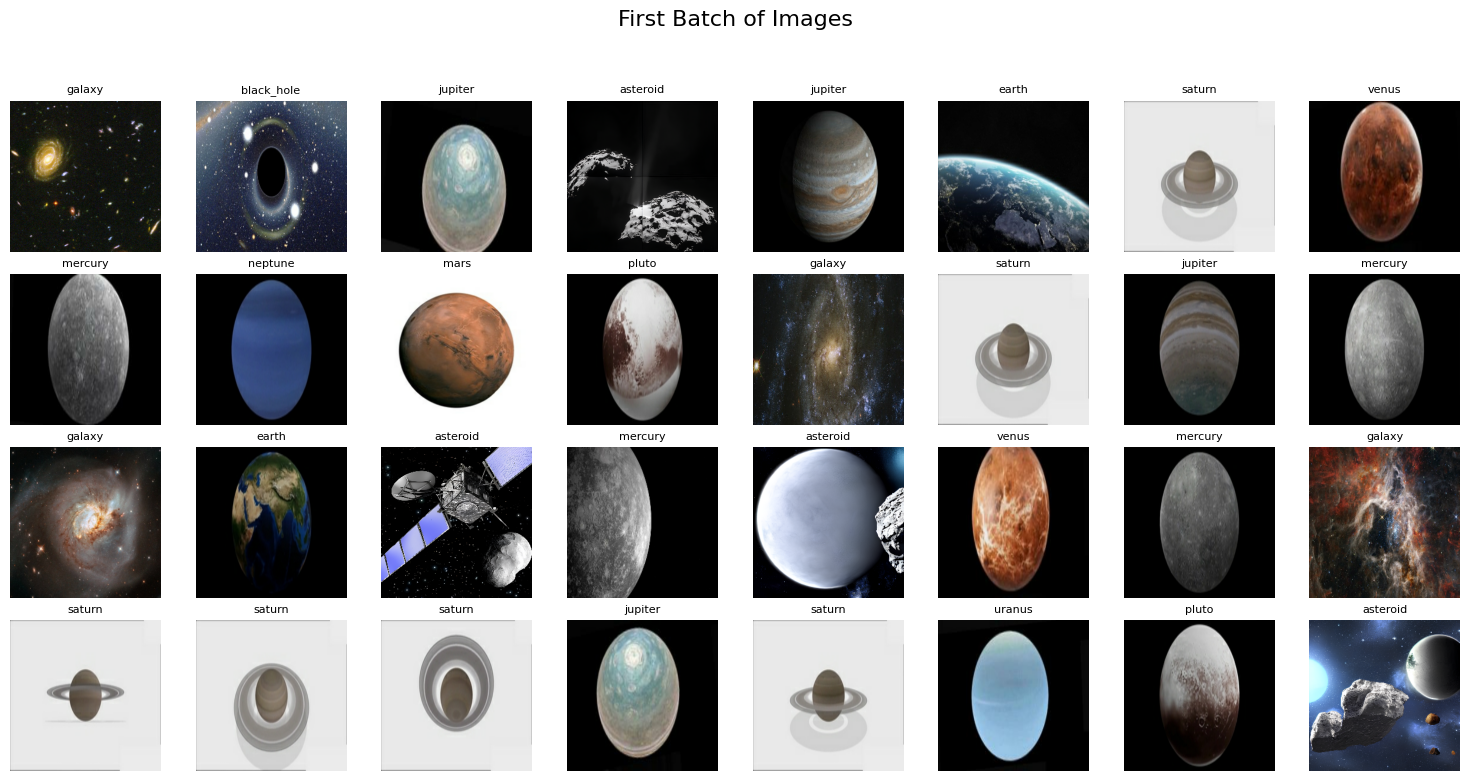

In [ ]:
for images, labels in training_batch.take(1):
    num_images = images.shape[0]
    rows = int(num_images / 8) + 1

    plt.figure(figsize=(15, 10))
    plt.suptitle("First Batch of Images", fontsize=16)
    for i in range(num_images):
        plt.subplot(rows, 8, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        # Get the class name for the title
        label_index = labels[i].numpy()
        title = training_batch.class_names[label_index]

        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    break

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

In [ ]:
preprocess = [
    Normalization(axis=-1), # we normalize the images per channel (RGB)
    RandomRotation(0.5), # random rotations of images
    RandomShear(x_factor=0.9, y_factor=0.9), # Random shear of images
    RandomZoom(0.2),
    RandomFlip(mode="horizontal_and_vertical") # Random flip of the images
    ]

## Model Implementaion


### Neural Network Implementaion

We will implement multiple pre-trained Convolutional Neural Networks (CNN) and fine-tune them to our astrophysical dataset. Such models include:
* VGG16
* VGG19
* ResNet
#### VGG 16

In [ ]:
mVGG16 = VGG16(include_top= False,
              input_shape=(256,256,3),
              pooling='avg',
              weights='imagenet',
              name = "vgg16")

# we will avoid training on previous layers
for layer in mVGG16.layers:
  layer.trainable = False

In [ ]:
mVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model = Sequential([Input(shape=(256,256,3), batch_size=BATCH_SIZE)] + preprocess + \
 [mVGG16,
  Dropout(0.5),
  Dense(256, activation='softmax'),
  Dense(len(class_names), activation='softmax')
  ])
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=0.001))

In [ ]:
model.fit(x=training_batch, validation_data=validation_batch, epochs=5, verbose=2, batch_size=BATCH_SIZE)

Epoch 1/5


### Trees Implementation